### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from google.colab import drive, files

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# point to the drive directory
endo_dir = '/content/drive/MyDrive/endometriosis/'

In [4]:
#Load topic modeling file
topic_model_file = os.path.join(endo_dir, 'output', 'topic-modeling', 'parags', 'endo+endometriosis-25_10.pkl')
tomo_df = pd.read_pickle(topic_model_file).reset_index().rename(columns = {"index":"id"}) # change index into column

# add column with info about where the paragraph comes from, whether post or comment
tomo_df['og_id'] = ['_'.join(x.split('_')[:3]) for x in tomo_df.id]
tomo_df['type'] = [x.split('_')[2] for x in tomo_df.id]

# select only those from posts
posts_tomo_df = tomo_df.loc[tomo_df['type'] == 'post']

# group paragraphs' distributions by the post/comment the paragraph comes from, taking the average of the distributions
posts_tomo_df = posts_tomo_df.groupby(['og_id'], sort=False).mean().reset_index().rename(columns = {"og_id":"id"}).drop(columns=['dominant_topic'])

print(len(posts_tomo_df))
posts_tomo_df[:1]

34190


<ipython-input-4-365c6c223a55>:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  posts_tomo_df = posts_tomo_df.groupby(['og_id'], sort=False).mean().reset_index().rename(columns = {"og_id":"id"}).drop(columns=['dominant_topic'])


,id,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24
0,Endo_otb0m_post,0.002148,0.004427,0.084569,0.002483,0.004032,0.005094,0.198672,0.051963,0.00399,...,0.002933,0.457867,0.003799,0.00451,0.002562,0.034702,0.005111,0.002024,0.003314,0.005033


In [5]:
intent_file = os.path.join(endo_dir, 'output', 'predictions', 'INTENT', 'intent_predictions.pkl')
intent = pd.read_pickle(intent_file)
print(len(intent))
intent[:1]

34715


,author,id,text,type,url,link_id,parent_id,subreddit,created_utc,time,predictions_SEEKING_EXPERIENCES,predictions_SEEKING_INFO,predictions_SEEKING_EMOTION,predictions_VENT,predictions_PROVIDING_EXPERIENCES
7,theonusta,Endo_otb0m_post,We've been a community of Endometriosis suppor...,post,http://www.reddit.com/r/Endo/comments/otb0m/up...,N/A,N/A,Endo,1327349669,2012-01-23 20:14:29,0,0,0,0,0


### Transform topic distributions to z-scores and add to the predictions

In [6]:
posts_zscores = posts_tomo_df.copy()
cols = list(posts_zscores.columns[1:26])
# get z scores for each topic column
for col in cols:
  posts_zscores[col] = stats.zscore(posts_zscores[col])
posts_zscores[:1]

,id,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24
0,Endo_otb0m_post,-0.23168,-0.387125,0.468209,-0.252115,-0.372082,-0.5427,2.547604,-0.02203,-0.346507,...,-0.243485,3.552453,-0.38399,-0.439752,-0.217652,-0.396432,-0.541009,-0.206036,-0.329309,-0.352841


In [7]:
big_df = intent[['id','predictions_SEEKING_EXPERIENCES','predictions_SEEKING_INFO', 'predictions_SEEKING_EMOTION', 'predictions_VENT']].merge(posts_zscores, how = "right", left_on = "id", right_on = "id")
print('Length df after merge:', len(big_df))
big_df[:10]

Length df after merge: 34190


,id,predictions_SEEKING_EXPERIENCES,predictions_SEEKING_INFO,predictions_SEEKING_EMOTION,predictions_VENT,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,...,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24
0,Endo_otb0m_post,0,0,0,0,-0.231680,-0.387125,0.468209,-0.252115,-0.372082,...,-0.243485,3.552453,-0.383990,-0.439752,-0.217652,-0.396432,-0.541009,-0.206036,-0.329309,-0.352841
1,Endo_p0e2x_post,0,0,0,0,-0.252657,0.665490,-0.006372,-0.278159,0.846265,...,-0.266231,-0.570831,-0.400928,-0.459575,-0.237345,-0.663145,0.057556,-0.222266,-0.018820,2.718165
2,Endo_pfivr_post,1,0,0,0,-0.256969,-0.415425,-0.455380,-0.283512,-0.402035,...,7.633163,0.573591,-0.404409,0.047363,-0.241393,-0.548202,-0.562620,-0.225601,-0.351940,-0.392340
3,Endo_pmaka_post,0,0,0,0,-0.241162,1.590840,-0.435489,-0.263887,-0.383313,...,-0.253766,-0.000597,-0.391646,-0.448712,-0.226554,-0.646861,-0.549112,-0.213372,-0.337795,-0.367651
4,Endo_qr632_post,1,0,0,0,-0.264543,1.621250,-0.464912,-0.292916,-0.173295,...,-0.279119,-0.591206,-0.410525,0.716092,-0.248504,-0.679981,-0.569093,-0.231461,-0.358718,4.617860
5,Endo_r2cq6_post,0,1,0,0,-0.249483,2.454260,-0.445960,-0.274218,-0.393168,...,-0.262789,-0.565389,-0.398365,0.367758,0.009592,-0.394208,-0.117697,-0.219810,-0.345241,1.685872
6,Endo_suaof_post,1,0,0,0,-0.248966,1.343153,0.740139,-0.273577,-0.392556,...,-0.262229,1.978462,-0.397947,-0.456087,-0.233880,-0.657916,-0.555781,-0.219410,-0.344778,-0.201898
7,Endo_t1scb_post,1,0,0,0,-0.211781,-0.364857,-0.398517,-0.227409,-0.348513,...,-0.221908,-0.267822,-0.367922,0.938752,-0.198971,-0.231778,-0.152910,-0.190641,-0.311502,-0.321760
8,Endo_tzrn0_post,0,1,0,0,-0.237508,1.013818,0.445697,-0.259351,-0.378985,...,-0.249804,0.553990,-0.388695,-0.445259,-0.223124,0.476080,0.469791,-0.210545,-0.334525,-0.361944
9,Endo_tzspb_post,1,0,0,0,-0.230443,-0.385741,0.550154,-0.250579,-0.370617,...,0.138597,-0.532750,-0.382991,1.634096,-0.216491,-0.631678,-0.250579,-0.205080,-0.328202,4.622752


### Create new df with topic zscores as rows and intents as columns

In [8]:
new_columns = []
intents = ['Seeking_Experiences', 'Seeking_Info', 'Seeking_Emotion', 'Vent']
for intent in intents:
  predictions_column_name = f'predictions_{intent.upper()}'
  intent_df = big_df[big_df[predictions_column_name] == 1]
  intent_col = pd.DataFrame(intent_df[intent_df.columns[5:]].mean()).rename(columns = {0:intent})
  new_columns.append(intent_col)
intents_zscores = pd.concat(new_columns, axis = 1)
intents_zscores

,Seeking_Experiences,Seeking_Info,Seeking_Emotion,Vent
Topic 0,0.015222,0.071450,-0.129687,-0.106918
Topic 1,0.019372,0.030722,-0.116605,-0.118427
Topic 2,0.013183,0.181003,-0.152028,-0.202921
Topic 3,0.031543,-0.025614,-0.036098,-0.071737
Topic 4,0.014268,0.184767,-0.146559,-0.159427
Topic 5,0.037840,0.208486,-0.196347,-0.246047
Topic 6,0.002530,-0.071934,-0.183227,-0.178351
Topic 7,-0.122727,-0.169947,0.582611,0.710249
Topic 8,-0.075942,-0.024992,0.044954,0.219223
Topic 9,-0.024740,0.058076,-0.090408,-0.098405


### Reorder and change index to topics full names

In [9]:
reordered_topic_names = ["Topic 0: Gastrointestinal",
    "Topic 3: Pelvic floor",
    "Topic 5: Menstruation",
    "Topic 17: Muscular ",
    "Topic 21: Sharing symptoms",
    "Topic 14: Pain management",
    "Topic 23: Drugs",
    "Topic 18: Hormonal drug experiences",
    "Topic 24: Info on hormonal drugs",
    "Topic 1: Information on surgery",
    "Topic 2: Medical information",
    "Topic 4: Getting diagnosed",
    "Topic 6: Online resources",
    "Topic 9: Specialists",
    "Topic 13: Insurance",
    "Topic 20: Medical appointments",
    "Topic 8: Post surgery recovery",
    "Topic 15: Product recommendations",
    "Topic 19: Diet",
    "Topic 22: Comfort items",
    "Topic 7: Dismissal",
    "Topic 10: Gratitude",
    "Topic 11: Medical stories",
    "Topic 12: Fertility",
    "Topic 16: Empathy",
    ]

In [10]:
reordered_topics_nums = [topic_name.split(":")[0] for topic_name in reordered_topic_names]
reordered_df = intents_zscores.reindex(reordered_topics_nums)
reordered_df[:2]

,Seeking_Experiences,Seeking_Info,Seeking_Emotion,Vent
Topic 0,0.015222,0.071450,-0.129687,-0.106918
Topic 3,0.031543,-0.025614,-0.036098,-0.071737


In [11]:
reordered_df['topics_names'] = [x.split(":")[1] for x in reordered_topic_names]
reordered_df.set_index('topics_names', inplace=True)
reordered_df[:2]

,Seeking_Experiences,Seeking_Info,Seeking_Emotion,Vent
topics_names,,,,
Gastrointestinal,0.015222,0.071450,-0.129687,-0.106918
Pelvic floor,0.031543,-0.025614,-0.036098,-0.071737


In [14]:
sns.color_palette("Oranges", 10)[9]

(0.6083967704728951, 0.19538638985005768, 0.012856593617839291)

In [66]:
sns.set(font_scale=1.8)

#cmap = sns.diverging_palette(145, 300, s=90, as_cmap=True) # purple high, green low
#cmap = sns.diverging_palette(300, 145, s=90, as_cmap=True) # green high, purple low
cmap = sns.diverging_palette(260, 16.5, s=90, as_cmap=True)

### Create big image

In [28]:
intent_d = {"Seeking_Experiences": "Seeking Experiences", "Seeking_Info": "Seeking Informational Support", "Seeking_Emotion": "Seeking Emotional Support", "Vent": "Venting"}
reordered_df = reordered_df.rename(columns = intent_d)

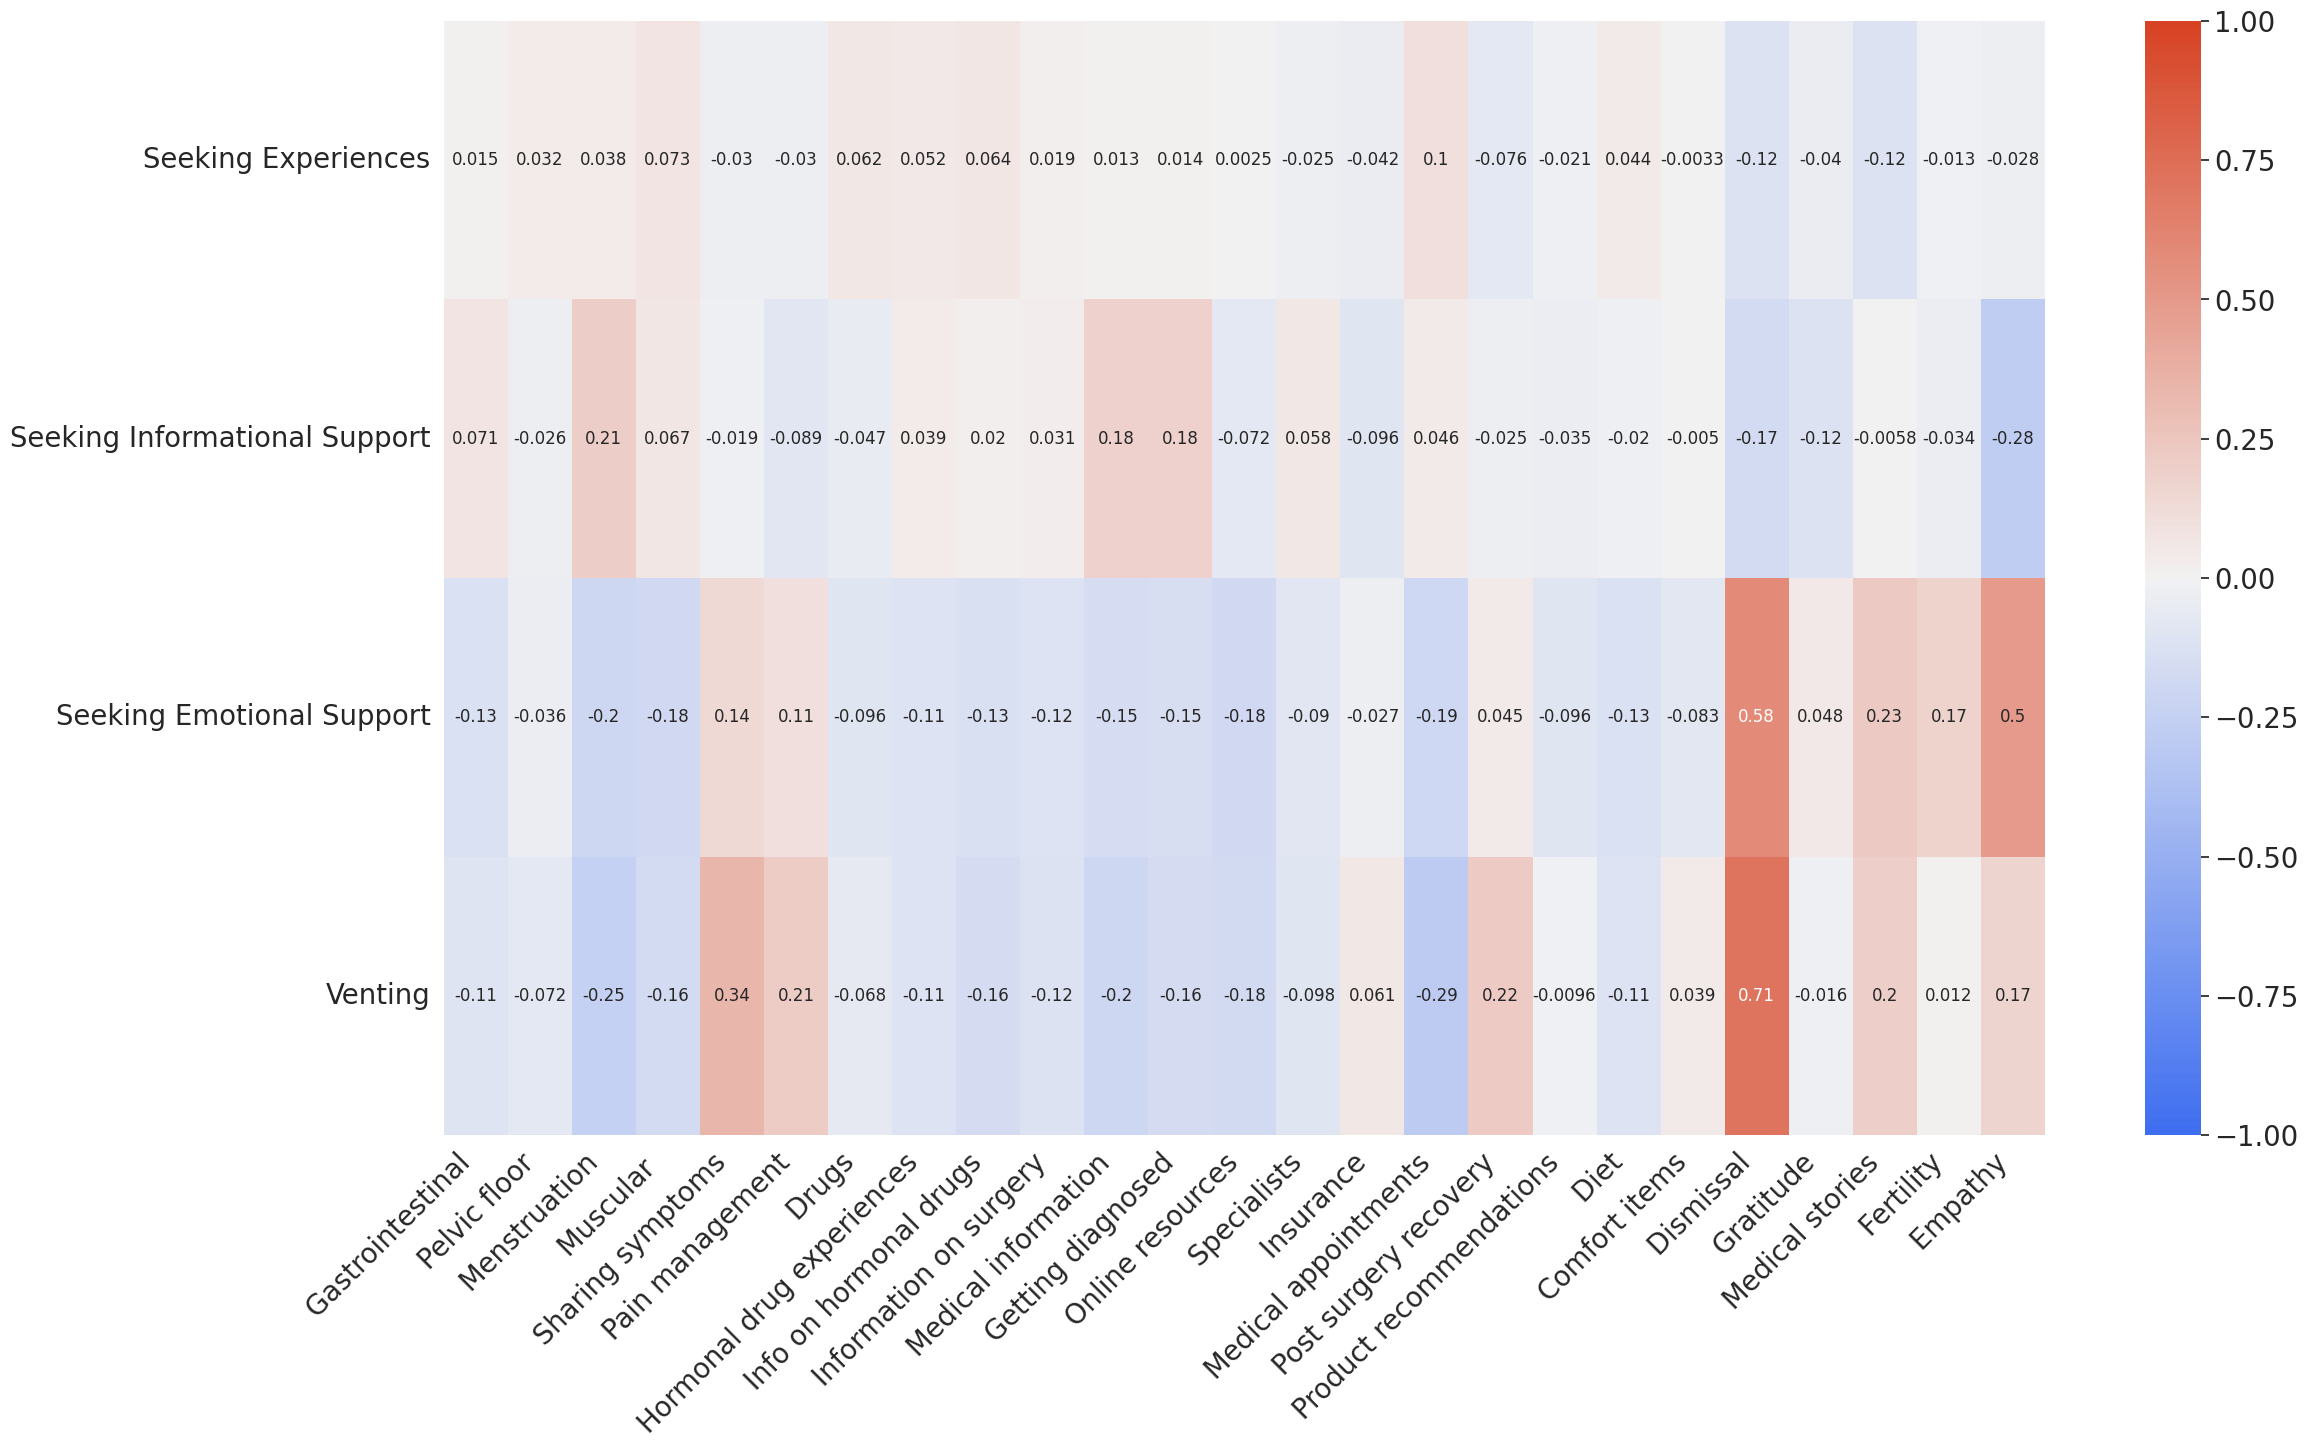

In [67]:
plt.figure(figsize=(25, 15))
heatmap = sns.heatmap(reordered_df.T, vmin=-1, vmax=1, center = 0, annot=True, annot_kws={"size": 12}, cmap=cmap)
plt.yticks(rotation=360, ha='right')
plt.xticks(rotation=45, ha='right')
plt.ylabel('', fontsize = 30)
plt.xlabel('', fontsize = 30)
plt.tight_layout()
plt.savefig(os.path.join(endo_dir, 'output', 'figures', 'Intent_Topics', 'general3a.png'), dpi = 300, bbox_inches = "tight")

### Code for permutation test

In [ ]:
def permute(input_array):
  # shuffle is inplace, so copy to preserve input
  permuted = input_array.copy().values  # convert to numpy array, avoiding warning
  np.random.shuffle(permuted)
  return permuted  # convert back to pandas

def permutation_test(ddf, persona, topic):
  column = f'predictions_{persona.upper()}'
  # Difference between the mean of the values in the first half and the mean of the values in the second half of the corpus
  real_mean_0 = ddf.loc[ddf[column] == 0][topic].mean()
  real_mean_1 = ddf.loc[ddf[column] == 1][topic].mean()
  diff_real = real_mean_0 - real_mean_1

  # Performing 1,000 permutations
  n_permutations = 1000
  flag = 0
  for i in range(n_permutations):
      copy = ddf.copy()  # we copy the original dataframe with the observed data
      copy[column] = permute(copy[column])  # we shuffle the 'year' column
      mean_before = copy.loc[copy[column] == 0][topic].mean()
      mean_after = copy.loc[copy[column] == 1][topic].mean()
      diff_perm = mean_before - mean_after  # we calculate the difference between the means of the two halves of the corpus
      if diff_real > 0:  # if real difference is a positive number
          if diff_real > diff_perm:  # we test if the observed difference is greater
              flag += 1
      if diff_real < 0:  # if real difference is a positive number
          if diff_real < diff_perm:  # we test if the observed difference is lesser
              flag += 1  # we keep count of the number of times the observed difference is larger
  p = (n_permutations-flag)/n_permutations

  return diff_real, flag, p

### Symptoms

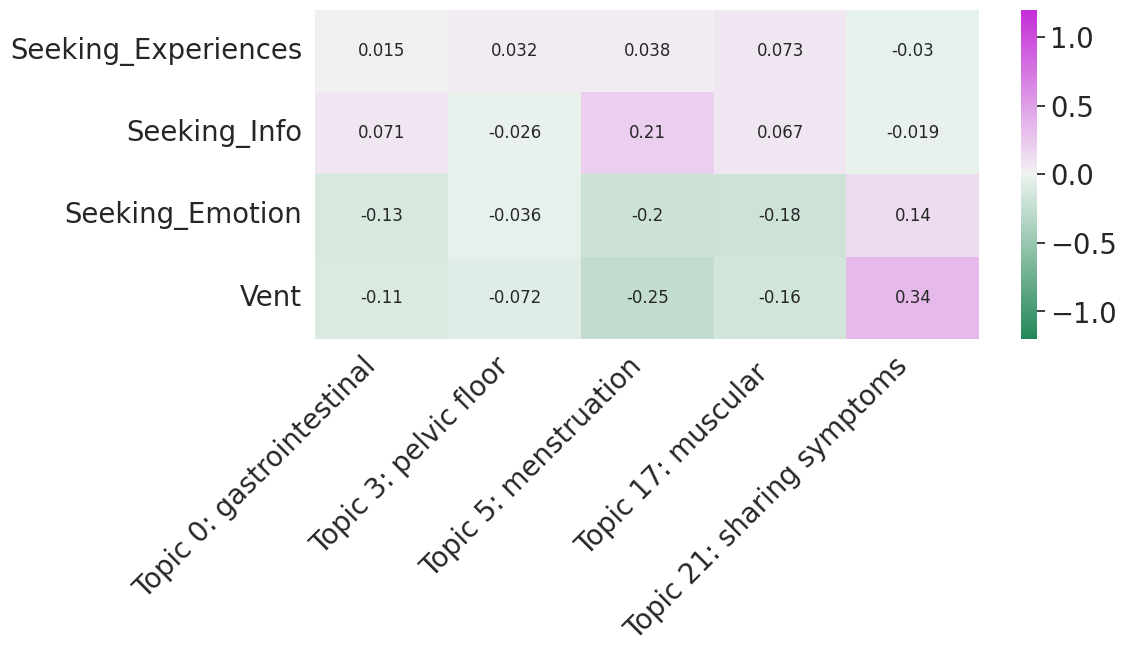

In [ ]:
plt.figure(figsize=(12, 7))
heatmap = sns.heatmap(reordered_df.iloc[0:5].T, vmin=-1.20, vmax=1.20, center = 0, annot=True, annot_kws={"size": 12}, cmap=cmap)
plt.yticks(rotation=360, ha='right')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.tight_layout()
plt.savefig(os.path.join(endo_dir, 'output', 'figures', 'Intent_Topics', 'intent_symptoms.png'), dpi = 300)

In [ ]:
# More talk of menstruation (5) with seeking info
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Info', 'Topic 5')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.2898082137107849
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# Less talk of sharing symptoms with seeking experiences
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Experiences', 'Topic 21')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.058939866721630096
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# Less talk of sharing symptoms with seeking info
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Info', 'Topic 21')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.026898670941591263
Number of times observed difference is larger than permutated: 984
P-value: 0.016



### Medications

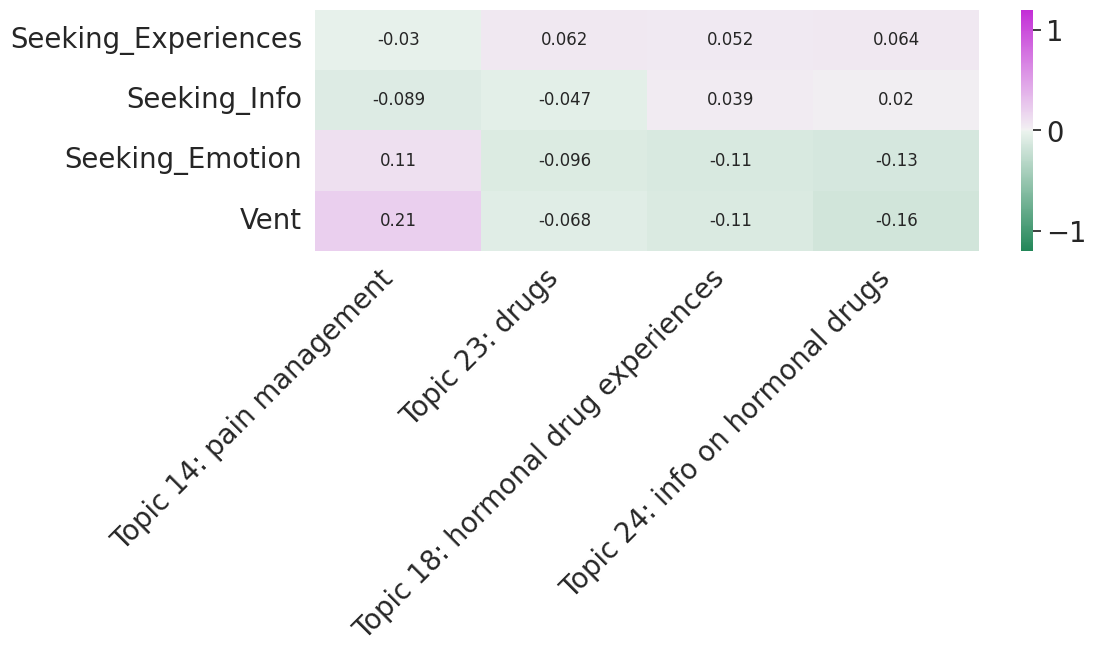

In [ ]:
plt.figure(figsize=(12, 7))
heatmap = sns.heatmap(reordered_df.iloc[5:9].T, vmin=-1.20, vmax=1.20, center=0, annot=True, annot_kws={"size": 12}, cmap=cmap)
plt.yticks(rotation=360, ha='right')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.tight_layout()
plt.savefig(os.path.join(endo_dir, 'output', 'figures', 'Intent_Topics', 'intent_medications.png'), dpi = 300)

In [ ]:
# Less pain management (14) with seeking info
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Info', 'Topic 14')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.12368375062942505
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# Less drugs (23) with seeking info
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Info', 'Topic 23')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.06533068418502808
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More horm drugs (23) with seeking experiences
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Experiences', 'Topic 23')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.12309202551841736
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More horm drug experiences (18) with seeking experiences
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Experiences', 'Topic 18')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.10256665199995041
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More horm drug experiences (18) with seeking info
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Info', 'Topic 18')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.05425196513533592
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More medical info on horm drugs (24) with seeking experiences
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Experiences', 'Topic 24')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.12606456875801086
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More medical info on horm drugs (24) with seeking info
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Info', 'Topic 24')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.027755064889788628
Number of times observed difference is larger than permutated: 993
P-value: 0.007



### Healthcare

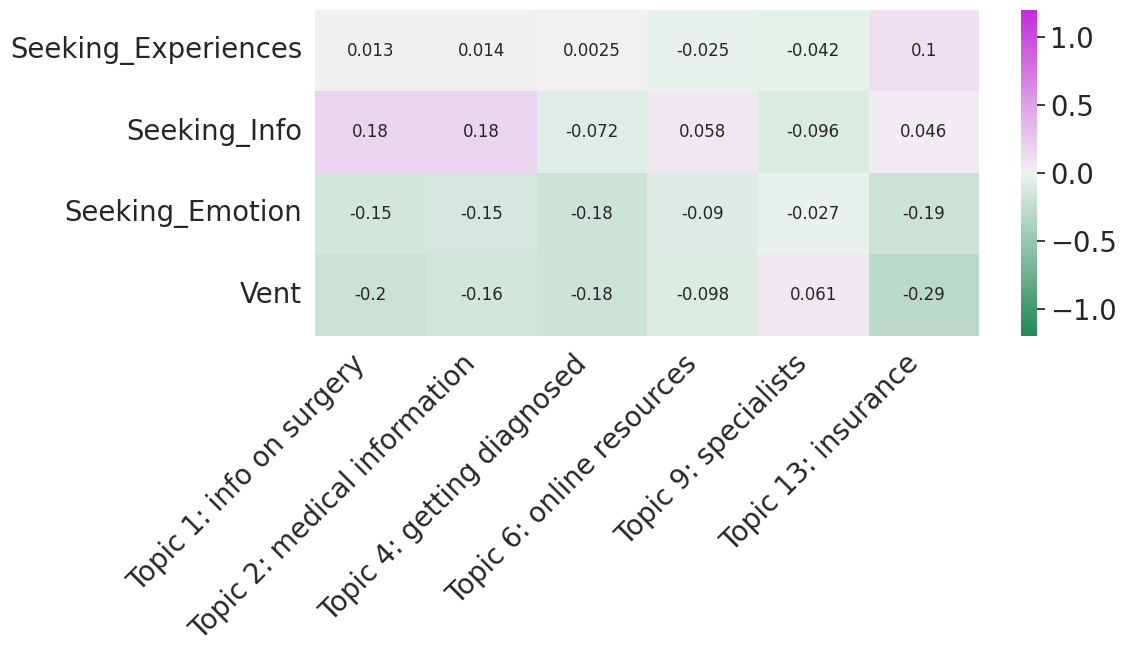

In [ ]:
plt.figure(figsize=(12, 7))
heatmap = sns.heatmap(reordered_df.iloc[9:15].T, vmin=-1.20, vmax=1.20, center = 0, annot=True, annot_kws={"size": 12}, cmap=cmap)
plt.yticks(rotation=360, ha='right')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.tight_layout()
plt.savefig(os.path.join(endo_dir, 'output', 'figures', 'Intent_Topics', 'intent_healthcare.png'), dpi = 300)

In [ ]:
# More medical appointment (4) with seeking experiences
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Info', 'Topic 4')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.2568383514881134
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More medical information (2) with seeking info
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Info', 'Topic 2')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.2516050934791565
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More getting diagnosed (4) with seeking info
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Info', 'Topic 4')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.2568383514881134
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More specialists (4) with seeking info
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Info', 'Topic 4')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.2568383514881134
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# Low insurance( 4) with seeking info
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Info', 'Topic 4')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.2568383514881134
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



### Self care

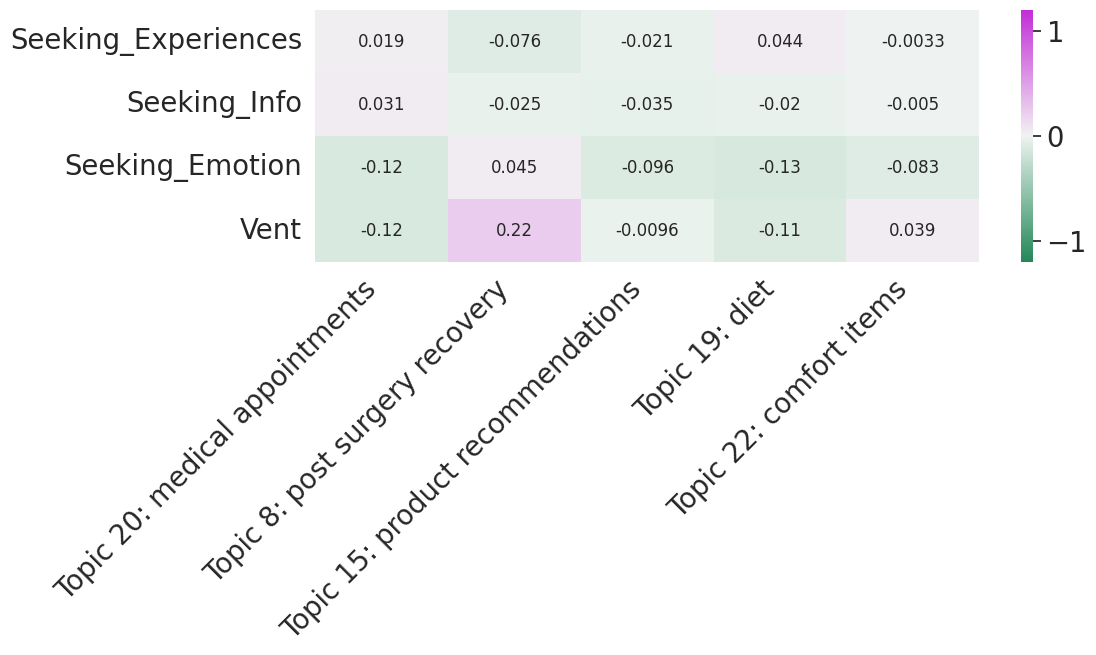

In [ ]:
plt.figure(figsize=(12, 7))
heatmap = sns.heatmap(reordered_df.iloc[15:20].T, vmin=-1.20, vmax=1.20, center = 0, annot=True, annot_kws={"size": 12}, cmap=cmap)
plt.yticks(rotation=360, ha='right')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.tight_layout()
plt.savefig(os.path.join(endo_dir, 'output', 'figures', 'Intent_Topics', 'intent_selfcare.png'), dpi = 300)

In [ ]:
# More talk about pre and post (1) with seeking experiences
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Experiences', 'Topic 1')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.03829110413789749
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More talk about diet (19) with seeking experiences
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Experiences', 'Topic 19')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.08652893453836441
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# Less talk about post (8) with seeking experiences
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Info', 'Topic 8')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.0347401425242424
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# Less talk about post (8) with seeking info
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Info', 'Topic 8')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.0347401425242424
Number of times observed difference is larger than permutated: 996
P-value: 0.004



### Life issues

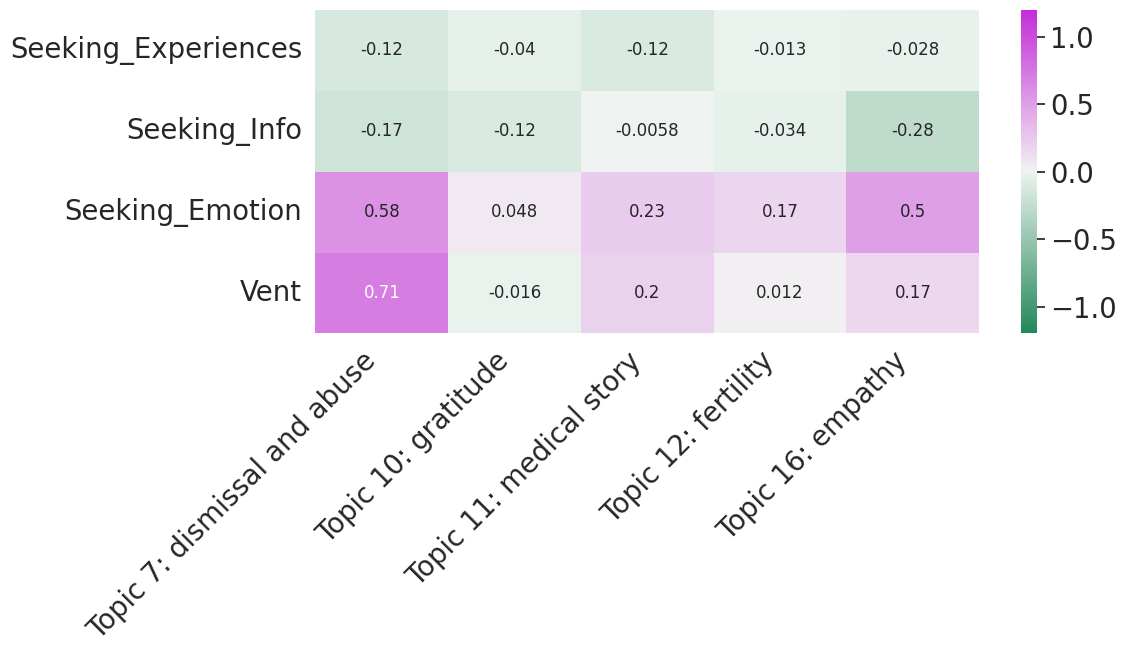

In [ ]:
plt.figure(figsize=(12, 7))
heatmap = sns.heatmap(reordered_df.iloc[20:25].T, vmin=-1.20, vmax=1.20, center = 0, annot=True, annot_kws={"size": 12}, cmap=cmap)
plt.yticks(rotation=360, ha='right')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.tight_layout()
plt.savefig(os.path.join(endo_dir, 'output', 'figures', 'Intent_Topics', 'intent_lifeissues.png'), dpi = 300)

In [ ]:
# More talk about gratitude (10) with seeking experiences
diff, flag_value, p_value = permutation_test(big_df, 'Vent', 'Topic 7')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.7884480357170105
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More talk about fertility (12) with seeking experiences
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Emotion', 'Topic 7')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.6907612085342407
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More talk about empathy (16) with seeking experiences
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Emotion', 'Topic 16')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.5917612314224243
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More talk about medical story (11) with seeking info
diff, flag_value, p_value = permutation_test(big_df, 'Seeking_Info', 'Topic 16')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.387980580329895
Number of times observed difference is larger than permutated: 1000
P-value: 0.0

